In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import zipfile

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print(f"Використовуємо {len(physical_devices)} GPU зі стратегією MirroredStrategy")
else:
    strategy = tf.distribute.get_strategy()
    print("Використовуємо стандартну стратегію розподілу")

print(f"Кількість пристроїв: {strategy.num_replicas_in_sync}")

Використовуємо стандартну стратегію розподілу
Кількість пристроїв: 1


In [ ]:
from google.colab import drive

# Підключення Google Drive
drive.mount('/content/drive')

# Шлях до архіву на Google Диску
GDRIVE_PATH = '/content/drive/MyDrive/archive.zip'

# Перевірка наявності архіву
if not os.path.exists(GDRIVE_PATH):
    raise FileNotFoundError("Файл 'archive.zip' не знайдено на Google Диску. Завантажте його у папку MyDrive.")
else:
    print("Архів знайдено на Google Диску")

Mounted at /content/drive
Архів знайдено на Google Диску


In [ ]:
!cp "{GDRIVE_PATH}" "archive.zip"

# Розпакування архіву
local_zip = 'archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('extracted')
zip_ref.close()
print("Архів успішно розпаковано")

# Встановлюємо шлях до розпакованих даних
DATA_DIR = 'extracted'
CSV_PATH = os.path.join(DATA_DIR, 'cards.csv')

Архів успішно розпаковано


In [ ]:
# Перевіряємо наявність файлу CSV і директорій
print(f"CSV файл існує: {os.path.exists(CSV_PATH)}")
print(f"Директорія train існує: {os.path.exists(os.path.join(DATA_DIR, 'train'))}")
print(f"Директорія valid існує: {os.path.exists(os.path.join(DATA_DIR, 'valid'))}")
print(f"Директорія test існує: {os.path.exists(os.path.join(DATA_DIR, 'test'))}")

# Перевіряємо вміст CSV файлу
df = pd.read_csv(CSV_PATH)
print("\nПерші 5 рядків CSV файлу:")
print(df.head())
print("\nІнформація про CSV файл:")
print(df.info())
print("\nРозподіл за набором даних:")
print(df['data set'].value_counts())
print("\nПеревірка балансу класів у тренувальному наборі:")
print(df[df['data set'] == 'train']['labels'].value_counts().describe())

CSV файл існує: True
Директорія train існує: True
Директорія valid існує: True
Директорія test існує: True

Перші 5 рядків CSV файлу:
   class index                   filepaths        labels card type data set
0            0  train/ace of clubs/001.jpg  ace of clubs       ace    train
1            0  train/ace of clubs/002.jpg  ace of clubs       ace    train
2            0  train/ace of clubs/003.jpg  ace of clubs       ace    train
3            0  train/ace of clubs/004.jpg  ace of clubs       ace    train
4            0  train/ace of clubs/005.jpg  ace of clubs       ace    train

Інформація про CSV файл:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class index  8155 non-null   int64 
 1   filepaths    8155 non-null   object
 2   labels       8155 non-null   object
 3   card type    8155 non-null   object
 4   data set     8155 non-null 

In [ ]:
# Константи та параметри
BATCH_SIZE = 32  # Стандартний розмір батча для GPU
IMAGE_SIZE_128 = (128, 128) # Зменшений розмір зображень для прискорення навчання
IMAGE_SIZE_200 = (200, 200)
NUM_CLASSES = 53  # 52 картки + 1 джокер
EPOCHS = 30  # Кількість епох

In [ ]:
def plot_training_history(history, title='Метрики навчання'):
    """Побудова графіків accuracy і loss"""
    plt.figure(figsize=(12, 5))

    # Графік точності
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Навчання')
    plt.plot(history.history['val_accuracy'], label='Валідація')
    plt.title(f'{title} - Точність')
    plt.xlabel('Епохи')
    plt.ylabel('Точність')
    plt.legend()

    # Графік функції втрат
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Навчання')
    plt.plot(history.history['val_loss'], label='Валідація')
    plt.title(f'{title} - Функція втрат')
    plt.xlabel('Епохи')
    plt.ylabel('Втрати')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Виводимо максимальну точність валідації
    val_acc_max = max(history.history['val_accuracy'])
    val_loss_min = min(history.history['val_loss'])
    print(f"Максимальна точність валідації: {val_acc_max:.4f}")
    print(f"Мінімальні втрати валідації: {val_loss_min:.4f}")

def plot_confusion_matrix(y_true, y_pred, classes, title='Матриця помилок'):
    """Побудова матриці помилок"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Істинний клас')
    plt.xlabel('Передбачений клас')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Базовий генератор без аугментації
train_datagen_base = ImageDataGenerator(
    rescale=1./255
)

# Генератор для валідації і тесту завжди без аугментації
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Створюємо генератори з директорій
train_generator_base = train_datagen_base.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=IMAGE_SIZE_128,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = valid_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'valid'),
    target_size=IMAGE_SIZE_128,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMAGE_SIZE_128,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Отримуємо відповідність між індексами та назвами класів
class_indices = train_generator_base.class_indices
class_names = list(class_indices.keys())
idx_to_class = {v: k for k, v in class_indices.items()}

print(f"Кількість тренувальних батчів: {len(train_generator_base)}")
print(f"Кількість валідаційних батчів: {len(validation_generator)}")
print(f"Кількість тестових батчів: {len(test_generator)}")
print(f"Всього класів: {len(class_names)}")

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Кількість тренувальних батчів: 239
Кількість валідаційних батчів: 9
Кількість тестових батчів: 9
Всього класів: 53


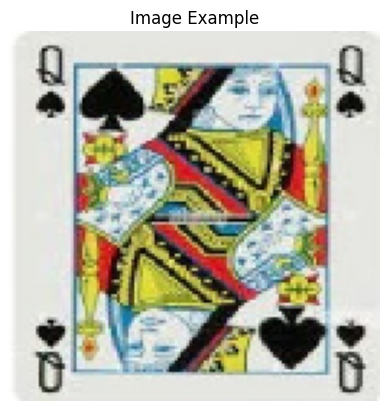

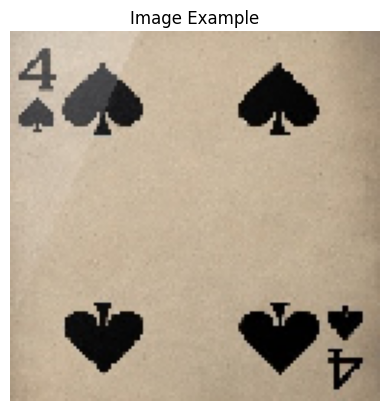

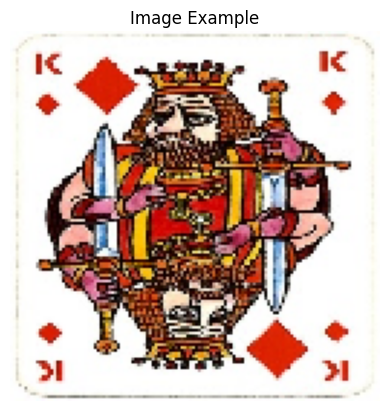

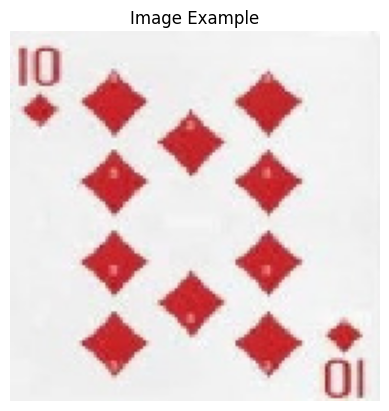

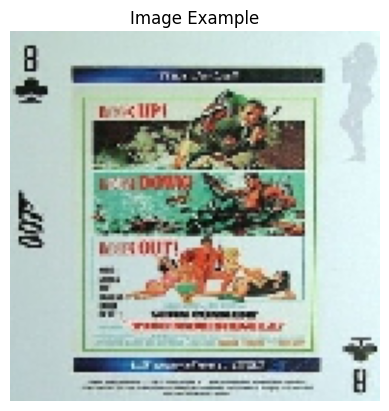

In [ ]:
# Визуализіруємо зображення
x_batch, y_batch = next(train_generator_base)
for i in range(5):
    plt.imshow(x_batch[i])
    plt.title("Image Example")
    plt.axis('off')
    plt.show()

Train class distribution: Counter({np.int32(3): 181, np.int32(19): 172, np.int32(2): 171, np.int32(16): 171, np.int32(18): 168, np.int32(36): 165, np.int32(30): 163, np.int32(32): 162, np.int32(29): 161, np.int32(17): 160, np.int32(5): 159, np.int32(11): 158, np.int32(40): 158, np.int32(44): 158, np.int32(12): 157, np.int32(51): 155, np.int32(52): 155, np.int32(14): 154, np.int32(28): 154, np.int32(46): 153, np.int32(6): 152, np.int32(37): 152, np.int32(24): 151, np.int32(42): 151, np.int32(8): 150, np.int32(35): 143, np.int32(48): 142, np.int32(41): 141, np.int32(15): 140, np.int32(31): 139, np.int32(38): 139, np.int32(4): 138, np.int32(9): 138, np.int32(10): 136, np.int32(7): 135, np.int32(22): 135, np.int32(27): 133, np.int32(50): 133, np.int32(49): 130, np.int32(1): 129, np.int32(26): 129, np.int32(43): 129, np.int32(21): 128, np.int32(39): 127, np.int32(45): 126, np.int32(23): 125, np.int32(25): 124, np.int32(34): 124, np.int32(0): 120, np.int32(20): 115, np.int32(13): 114, np.int

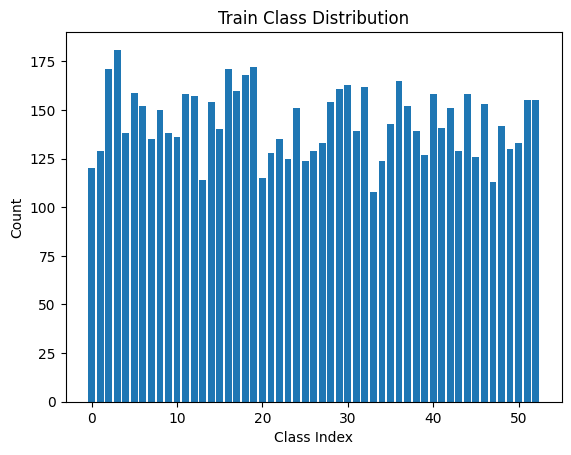

In [ ]:
from collections import Counter

labels = train_generator_aug.classes
label_counts = Counter(labels)
print(f"Train class distribution: {label_counts}")

plt.bar(label_counts.keys(), label_counts.values())
plt.title("Train Class Distribution")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

In [ ]:
# Модель 0: Дуже спрощена CNN
def build_cnn_very_simple(input_shape=IMAGE_SIZE_128 + (3,), num_classes=NUM_CLASSES):
    model = Sequential([
        # Перший блок згортки
            Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape),
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            MaxPooling2D((2, 2)),

            # Другий блок згортки
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Третій блок згортки
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Класифікатор
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
# Ініціалізація моделі
cnn_very_simple = build_cnn_very_simple()
cnn_very_simple.summary()

# Навчання моделі
history_cnn_very_simple = cnn_very_simple.fit(
    train_generator_base,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_cnn_very_simple.h5', monitor='val_accuracy', save_best_only=True)
    ],
    verbose=1
)

# Оцінка на тестовому наборі
test_loss, test_accuracy = cnn_very_simple.evaluate(test_generator)
print(f"Тестова точність дуже спрощеної CNN: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,305,301 (16.42 MB)

 Trainable params: 4,305,301 (16.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.0928 - loss: 3.6363

239/239 ━━━━━━━━━━━━━━━━━━━━ 23s 66ms/step - accuracy: 0.0936 - loss: 3.6325 - val_accuracy: 0.4679 - val_loss: 1.7469
Epoch 2/30
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4052 - loss: 2.1820

239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4055 - loss: 2.1808 - val_accuracy: 0.6642 - val_loss: 1.2601
Epoch 3/30
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5618 - loss: 1.5546

239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.5620 - loss: 1.5541 - val_accuracy: 0.7585 - val_loss: 0.9054
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.6912 - loss: 1.0688 - val_accuracy: 0.7547 - val_loss: 0.7738
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7580 - loss: 0.8026

239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.7580 - loss: 0.8026 - val_accuracy: 0.7962 - val_loss: 0.7667
Epoch 6/30
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8190 - loss: 0.5953

239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8189 - loss: 0.5954 - val_accuracy: 0.8113 - val_loss: 0.8510
Epoch 7/30
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8490 - loss: 0.4911

239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8490 - loss: 0.4912 - val_accuracy: 0.8340 - val_loss: 0.7467
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8791 - loss: 0.4018 - val_accuracy: 0.8000 - val_loss: 0.9264
Epoch 9/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.8812 - loss: 0.3767 - val_accuracy: 0.8340 - val_loss: 0.8809
Epoch 10/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9030 - loss: 0.3025 - val_accuracy: 0.8113 - val_loss: 0.8227
Epoch 11/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.9176 - loss: 0.2622 - val_accuracy: 0.8189 - val_loss: 0.8521
Epoch 12/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9233 - loss: 0.2257 - val_accuracy: 0.8264 - val_loss: 0.9333
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8391 - loss: 0.7273
Тестова точність дуже спрощеної CNN: 0.8264


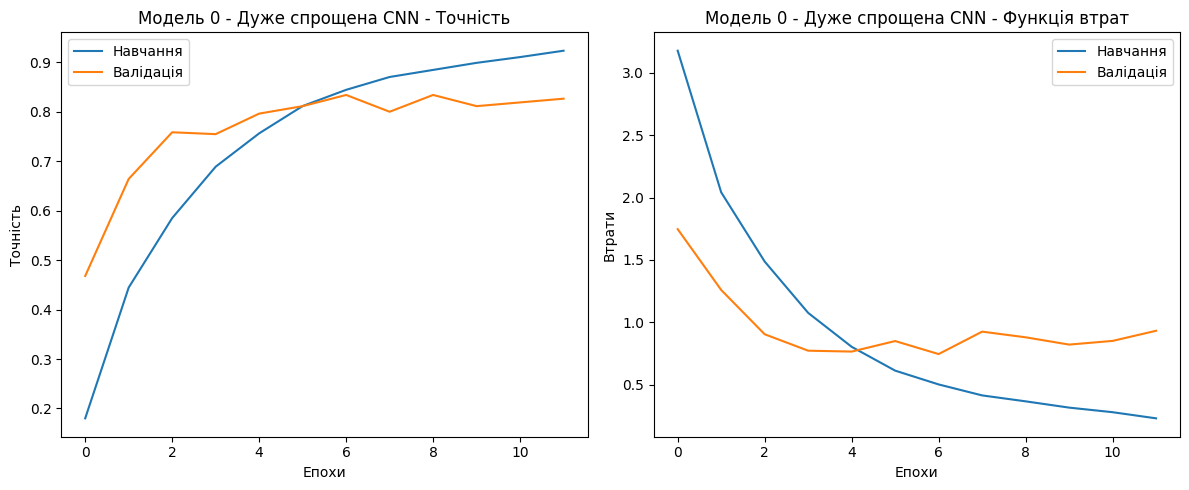

Максимальна точність валідації: 0.8340
Мінімальні втрати валідації: 0.7467


In [ ]:
# Візуалізація результатів
plot_training_history(history_cnn_very_simple, title='Модель 0 - Дуже спрощена CNN')

In [ ]:
def build_simple_cnn(input_shape=(128, 128, 3), num_classes=53):
    with strategy.scope():
        model = Sequential([
            # Перший блок згортки
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Другий блок згортки
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Третій блок згортки
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Класифікатор
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,689,493 (33.15 MB)

 Trainable params: 8,689,493 (33.15 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.0398 - loss: 3.8979 - val_accuracy: 0.3660 - val_loss: 2.3854
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.3300 - loss: 2.4718 - val_accuracy: 0.6868 - val_loss: 1.2089
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.5592 - loss: 1.6313 - val_accuracy: 0.7698 - val_loss: 0.8088
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.6572 - loss: 1.2053 - val_accuracy: 0.8038 - val_loss: 0.6458
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7423 - loss: 0.8874 - val_accuracy: 0.8377 - val_loss: 0.6054
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.7902 - loss: 0.6854 - val_accuracy: 0.8453 - val_loss: 0.5957
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8226 - loss: 0.5867 - val_accuracy: 0.8377 - val_loss: 0.6441
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8474 - loss: 0.4919 - 

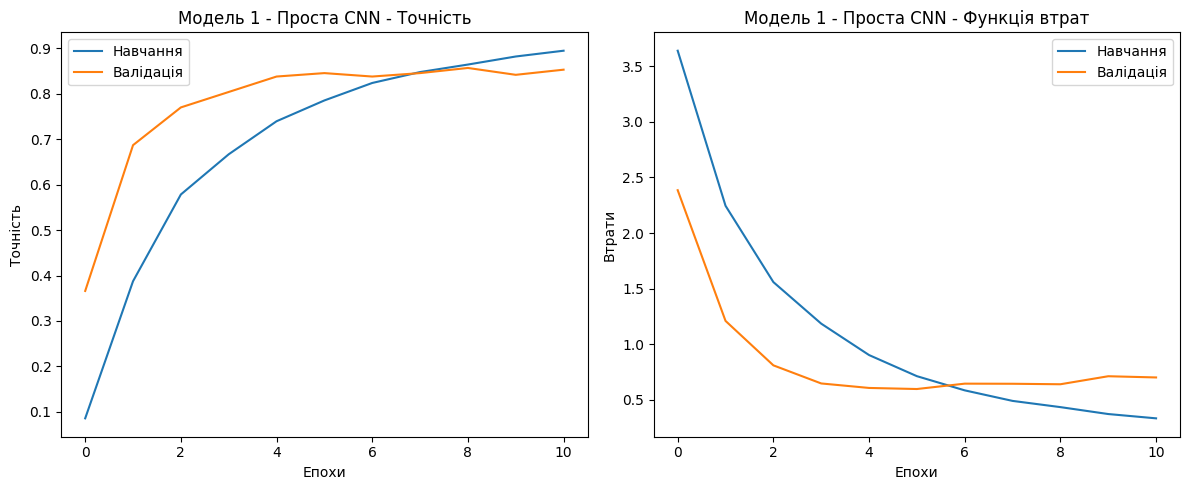

Максимальна точність валідації: 0.8566
Мінімальні втрати валідації: 0.5957


In [ ]:
# Будуємо модель
simple_cnn = build_simple_cnn()
simple_cnn.summary()

# Навчаємо модель
history_simple_cnn = simple_cnn.fit(
    train_generator_base,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_simple_cnn.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = simple_cnn.evaluate(test_generator)
print(f"Тестова точність базової CNN: {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_simple_cnn, title='Модель 1 - Проста CNN')

In [ ]:
def build_simple_cnn200(input_shape=(200, 200, 3), num_classes=53):
    with strategy.scope():
        model = Sequential([
            # Перший блок згортки
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Другий блок згортки
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Третій блок згортки
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),

            # Класифікатор
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 200, 200, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 200, 200, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 80000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      20,480,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 53)                  │          13,621 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,780,885 (79.27 MB)

 Trainable params: 20,780,885 (79.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 48s 141ms/step - accuracy: 0.0431 - loss: 3.8801 - val_accuracy: 0.2792 - val_loss: 2.4635
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.2647 - loss: 2.6853 - val_accuracy: 0.6226 - val_loss: 1.2912
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step - accuracy: 0.5192 - loss: 1.7016 - val_accuracy: 0.7585 - val_loss: 0.9304
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.6436 - loss: 1.2681 - val_accuracy: 0.7774 - val_loss: 0.8141
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - accuracy: 0.7359 - loss: 0.9048 - val_accuracy: 0.8038 - val_loss: 0.7555
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.7809 - loss: 0.7263 - val_accuracy: 0.8113 - val_loss: 0.7615
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - accuracy: 0.8311 - loss: 0.5510 - val_accuracy: 0.8113 - val_loss: 0.8676
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.8488 - loss: 0.5023 - val

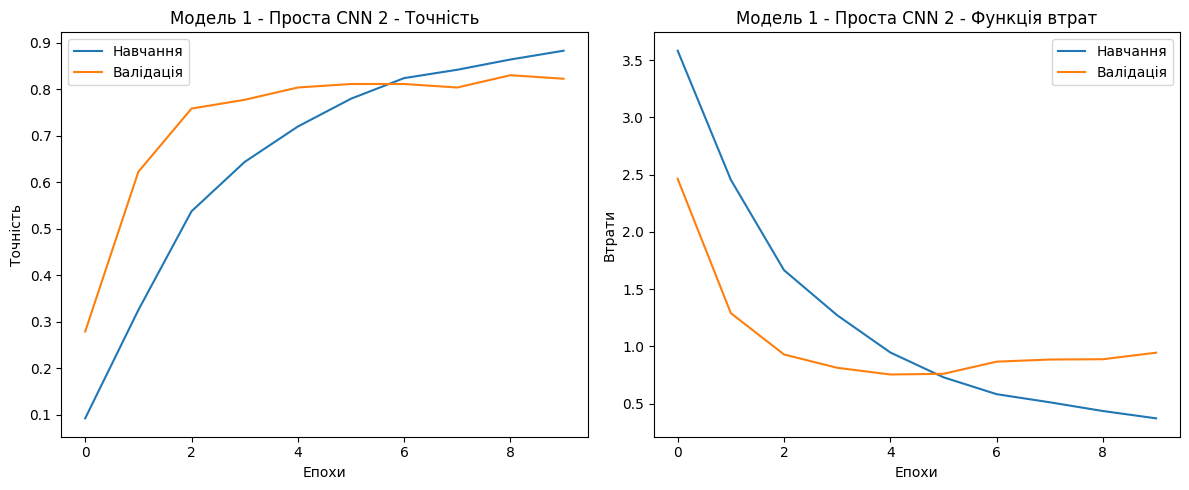

Максимальна точність валідації: 0.8302
Мінімальні втрати валідації: 0.7555


In [ ]:
# Будуємо модель
simple_cnn200 = build_simple_cnn200()
simple_cnn200.summary()

# Навчаємо модель
history_simple_cnn200 = simple_cnn200.fit(
    train_generator_base,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_simple_cnn200.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = simple_cnn200.evaluate(test_generator)
print(f"Тестова точність базової CNN 200 x 200: {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_simple_cnn200, title='Модель 1.1 - Проста CNN 200 x 200')

In [ ]:
# Генератор з сильною аугментацією
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Випадковий поворот
    width_shift_range=0.1,   # Випадковий зсув по ширині
    height_shift_range=0.1,  # Випадковий зсув по висоті
    zoom_range=0.1,          # Випадкове масштабування
    horizontal_flip=False,   # Карти не перевертаємо по горизонталі
    vertical_flip=False,     # Карти не перевертаємо по вертикалі
    brightness_range=[0.9, 1.1], # Невелика зміна яскравості
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=IMAGE_SIZE_128,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 7624 images belonging to 53 classes.


Found 7624 images belonging to 53 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,689,493 (33.15 MB)

 Trainable params: 8,689,493 (33.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - accuracy: 0.0268 - loss: 3.9514 - val_accuracy: 0.1698 - val_loss: 3.0701
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 77s 182ms/step - accuracy: 0.1235 - loss: 3.2710 - val_accuracy: 0.2755 - val_loss: 2.4912
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.1746 - loss: 2.9112 - val_accuracy: 0.4717 - val_loss: 1.7824
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.2954 - loss: 2.4260 - val_accuracy: 0.5208 - val_loss: 1.4764
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 42s 177ms/step - accuracy: 0.3497 - loss: 2.2550 - val_accuracy: 0.5774 - val_loss: 1.2995
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 182ms/step - accuracy: 0.3843 - loss: 2.0852 - val_accuracy: 0.5962 - val_loss: 1.2008
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.4160 - loss: 1.9707 - val_accuracy: 0.6943 - val_loss: 1.1005
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.4357 - loss: 1

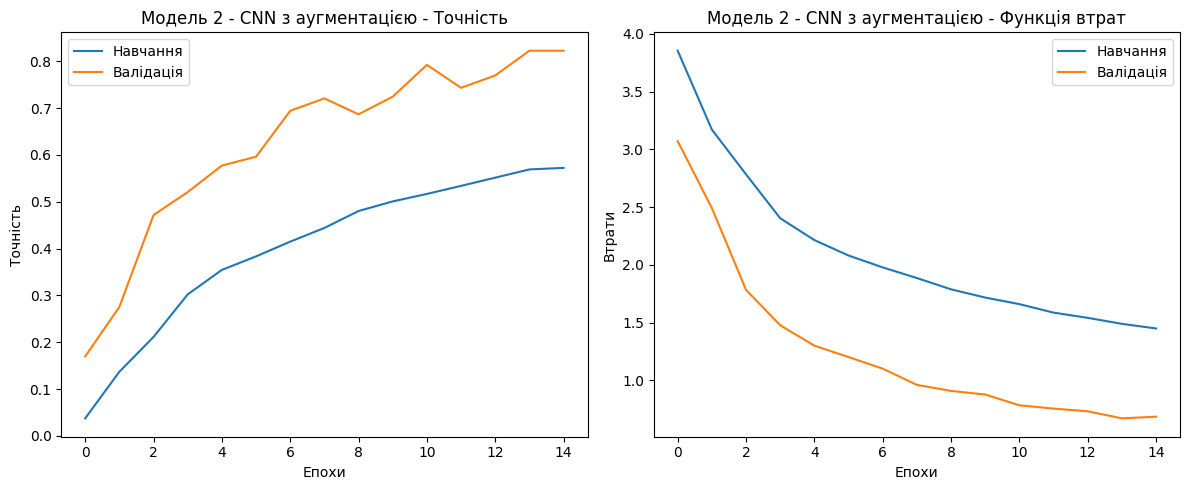

Максимальна точність валідації: 0.8226
Мінімальні втрати валідації: 0.6703


In [ ]:
# Використовуємо архітектуру моделі 1, але навчаємо з аугментованими даними
augmented_cnn = build_simple_cnn()
augmented_cnn.summary()

# Навчаємо модель
history_augmented_cnn = augmented_cnn.fit(
    train_generator_augmented,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_augmented_cnn.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = augmented_cnn.evaluate(test_generator)
print(f"Тестова точність CNN з аугментацією: {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_augmented_cnn, title='Модель 2 - CNN з аугментацією')

Висновок: занадто сильна аугментація

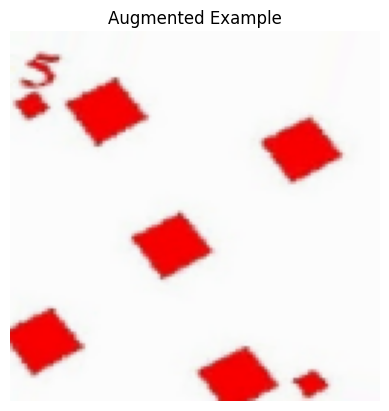

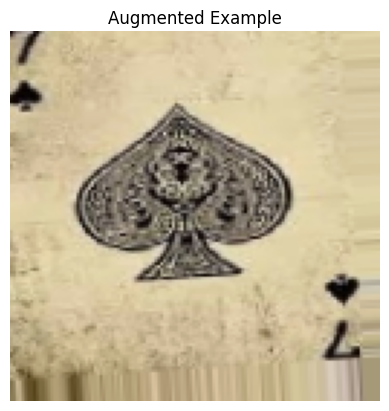

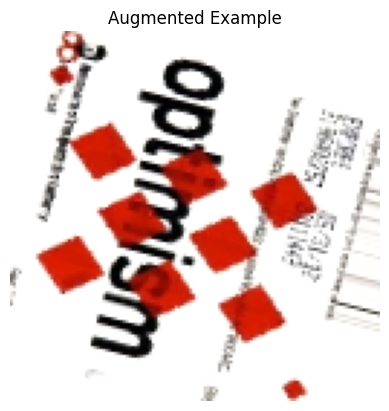

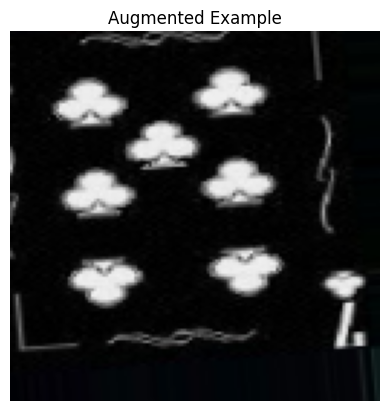

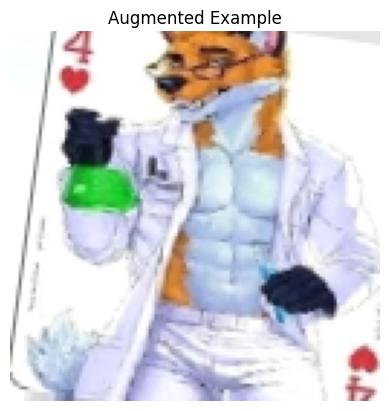

In [ ]:
# Визуализіруємо аугментированні зображення
x_batch, y_batch = next(train_generator_augmented)
for i in range(5):
    plt.imshow(x_batch[i])
    plt.title("Augmented Example")
    plt.axis('off')
    plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,692,309 (33.16 MB)

 Trainable params: 8,690,901 (33.15 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 64s 221ms/step - accuracy: 0.0883 - loss: 3.9923 - val_accuracy: 0.0868 - val_loss: 3.7430
Epoch 2/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 67s 182ms/step - accuracy: 0.2103 - loss: 2.9162 - val_accuracy: 0.2830 - val_loss: 3.5154
Epoch 3/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.2211 - loss: 2.9341 - val_accuracy: 0.3547 - val_loss: 2.1631
Epoch 4/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 181ms/step - accuracy: 0.2601 - loss: 2.7560 - val_accuracy: 0.4075 - val_loss: 1.8275
Epoch 5/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.3096 - loss: 2.4584 - val_accuracy: 0.4528 - val_loss: 1.6196
Epoch 6/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 184ms/step - accuracy: 0.3070 - loss: 2.4319 - val_accuracy: 0.5321 - val_loss: 1.4548
Epoch 7/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 182ms/step - accuracy: 0.3841 - loss: 2.1938 - val_accuracy: 0.6151 - val_loss: 1.2566
Epoch 8/15
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.4026 - loss: 2

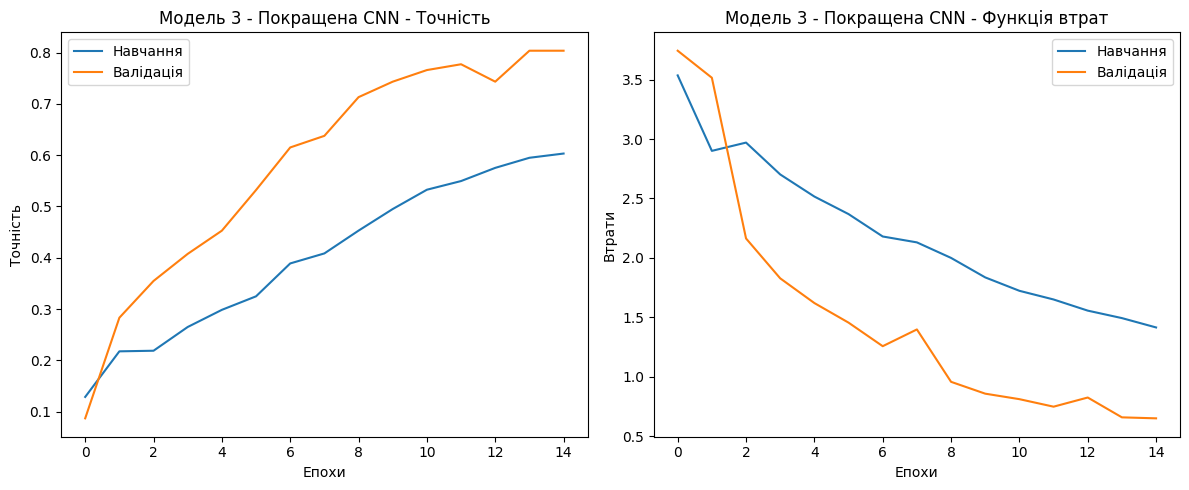

Максимальна точність валідації: 0.8038
Мінімальні втрати валідації: 0.6494


In [ ]:
def build_improved_cnn(input_shape=(128, 128, 3), num_classes=53):
    with strategy.scope():
        model = Sequential([
            # Перший блок згортки
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # Другий блок згортки
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # Третій блок згортки
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),
            Dropout(0.25),

            # Класифікатор
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.0005),  # Менша швидкість навчання
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Будуємо покращену модель
improved_cnn = build_improved_cnn()
improved_cnn.summary()

# Навчаємо модель з аугментацією
history_improved_cnn = improved_cnn.fit(
    train_generator_augmented, ## Сильна аугментація
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_improved_cnn.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = improved_cnn.evaluate(test_generator)
print(f"Тестова точність покращеної CNN: {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_improved_cnn, title='Модель 3 - Покращена CNN')

In [ ]:
# Екпериментування з аугментацію
# Повторення коду
valid_test_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = valid_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'valid'),
    target_size=IMAGE_SIZE_128,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMAGE_SIZE_128,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

train_datagen_aug = ImageDataGenerator( # Нова аугментація
    rescale=1./255,
    rotation_range=10,      # Менший кут повороту (карти чутливі до орієнтації)
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,        # Менше масштабування
    shear_range=10,       # невеликий нахил
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=IMAGE_SIZE_128,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print(f"Кількість тренувальних батчів: {len(train_generator_aug)}")
print(f"Кількість валідаційних батчів: {len(validation_generator)}")
print(f"Кількість тестових батчів: {len(test_generator)}")
print(f"Всього класів: {len(class_names)}")

Found 265 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 7624 images belonging to 53 classes.
Кількість тренувальних батчів: 239
Кількість валідаційних батчів: 9
Кількість тестових батчів: 9
Всього класів: 53


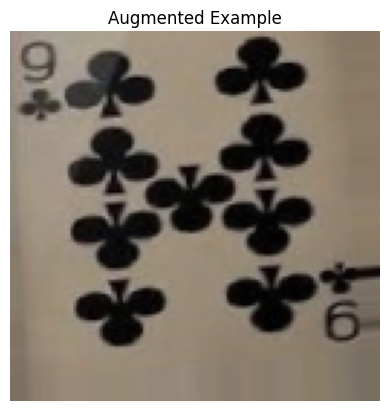

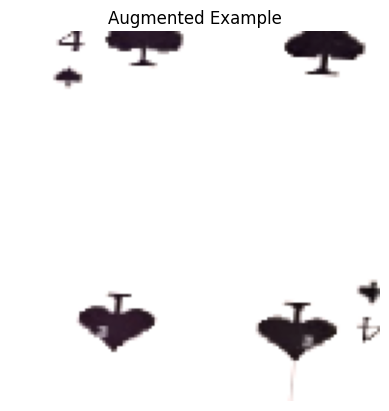

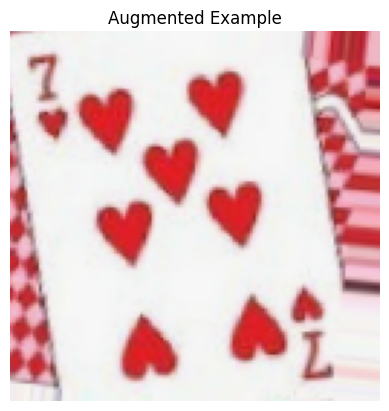

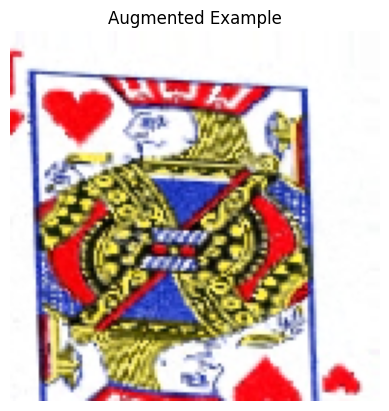

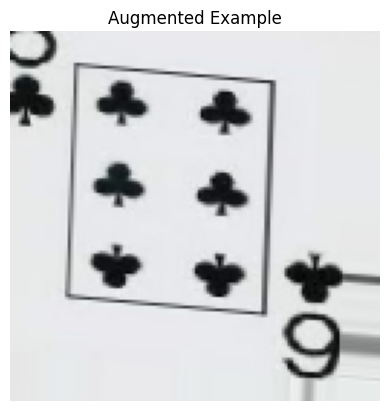

In [ ]:
# Визуализіруємо аугментированні зображення
x_batch, y_batch = next(train_generator_aug)
for i in range(5):
    plt.imshow(x_batch[i])
    plt.title("Augmented Example")
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_78 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_79 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 53)                  │          13,621 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,689,493 (33.15 MB)

 Trainable params: 8,689,493 (33.15 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 58s 220ms/step - accuracy: 0.0214 - loss: 3.9927 - val_accuracy: 0.1132 - val_loss: 3.3961
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 189ms/step - accuracy: 0.1176 - loss: 3.4100 - val_accuracy: 0.2377 - val_loss: 2.5459
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 189ms/step - accuracy: 0.1601 - loss: 2.9773 - val_accuracy: 0.3094 - val_loss: 2.2216
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 83s 192ms/step - accuracy: 0.2137 - loss: 2.6962 - val_accuracy: 0.4906 - val_loss: 1.7031
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 189ms/step - accuracy: 0.3140 - loss: 2.3479 - val_accuracy: 0.5472 - val_loss: 1.4091
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.3768 - loss: 2.1026 - val_accuracy: 0.6038 - val_loss: 1.2408
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.4088 - loss: 1.9751 - val_accuracy: 0.6302 - val_loss: 1.1424
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 52s 219ms/step - accuracy: 0.4684 - loss: 1

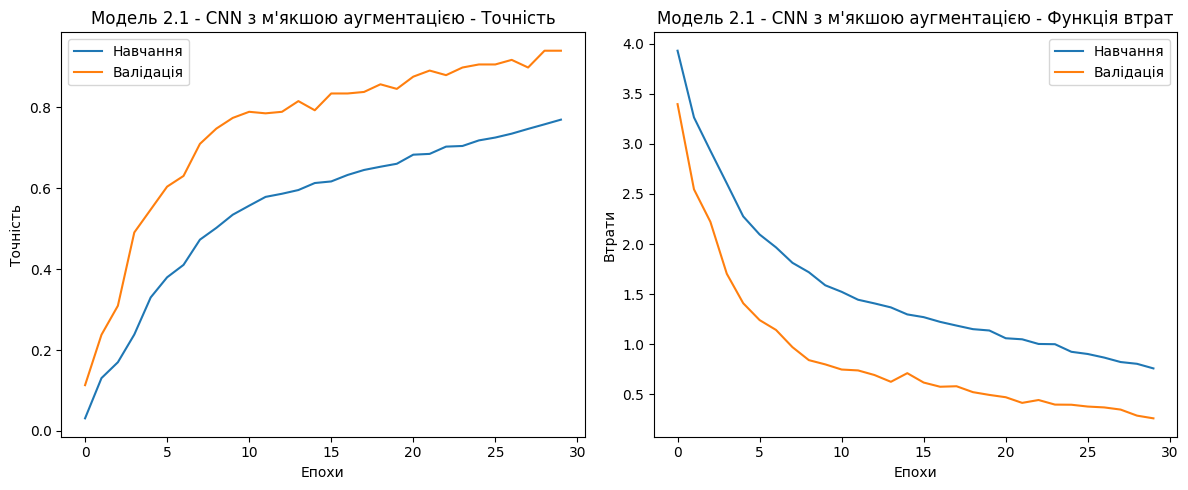

Максимальна точність валідації: 0.9396
Мінімальні втрати валідації: 0.2602


In [ ]:
# %% CELL: Модель 2.1 - CNN з м'якшою аугментацією
# Використовуємо ту ж архітектуру CNN, але з м'якшою аугментацією
cnn_aug2 = build_simple_cnn()
cnn_aug2.summary()

# Навчаємо модель
history_cnn_aug2 = cnn_aug2.fit(
    train_generator_aug, # (слабка)
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_cnn_aug2.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = cnn_aug2.evaluate(test_generator)
print(f"Тестова точність CNN з м'якшою аугментацією: {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_cnn_aug2, title='Модель 2.1 - CNN з м\'якшою аугментацією')

In [ ]:
def build_improved_cnn2(input_shape=(128, 128, 3), num_classes=53):
    with strategy.scope():
        model = Sequential([
            # Перший блок згортки
            Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            # Другий блок згортки
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(64, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            # Третій блок згортки
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(128, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2)),

            # Класифікатор
            Flatten(),
            Dense(256, activation='relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.005), ## Більша швидкість навчання
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Будуємо покращену модель
improved_cnn2 = build_improved_cnn2()
improved_cnn2.summary()

# Навчаємо модель з аугментацією
history_improved_cnn2 = improved_cnn2.fit(
    train_generator_aug, # (слабка)
    validation_data=validation_generator,
    epochs=40,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_improved_cnn2_no_aug.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = improved_cnn2.evaluate(test_generator)
print(f"Тестова точність покращеної CNN: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_84 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_85 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_43               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_86 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_87 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_43 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_88 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_89 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_44 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 8,692,309 (33.16 MB)

 Trainable params: 8,690,901 (33.15 MB)

 Non-trainable params: 1,408 (5.50 KB)

Epoch 1/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 62s 221ms/step - accuracy: 0.1070 - loss: 4.0887 - val_accuracy: 0.3434 - val_loss: 2.1192
Epoch 2/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 69s 182ms/step - accuracy: 0.2361 - loss: 2.7676 - val_accuracy: 0.1849 - val_loss: 3.0488
Epoch 3/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 48s 201ms/step - accuracy: 0.3064 - loss: 2.4195 - val_accuracy: 0.3811 - val_loss: 2.0745
Epoch 4/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 194ms/step - accuracy: 0.3941 - loss: 2.1383 - val_accuracy: 0.5962 - val_loss: 1.2779
Epoch 5/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.4628 - loss: 1.9029 - val_accuracy: 0.4981 - val_loss: 1.9653
Epoch 6/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 193ms/step - accuracy: 0.5160 - loss: 1.7038 - val_accuracy: 0.7396 - val_loss: 0.8850
Epoch 7/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.5483 - loss: 1.6059 - val_accuracy: 0.7547 - val_loss: 0.7453
Epoch 8/40
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.6007 - loss: 1

NameError: name 'history_improved_cnn3' is not defined

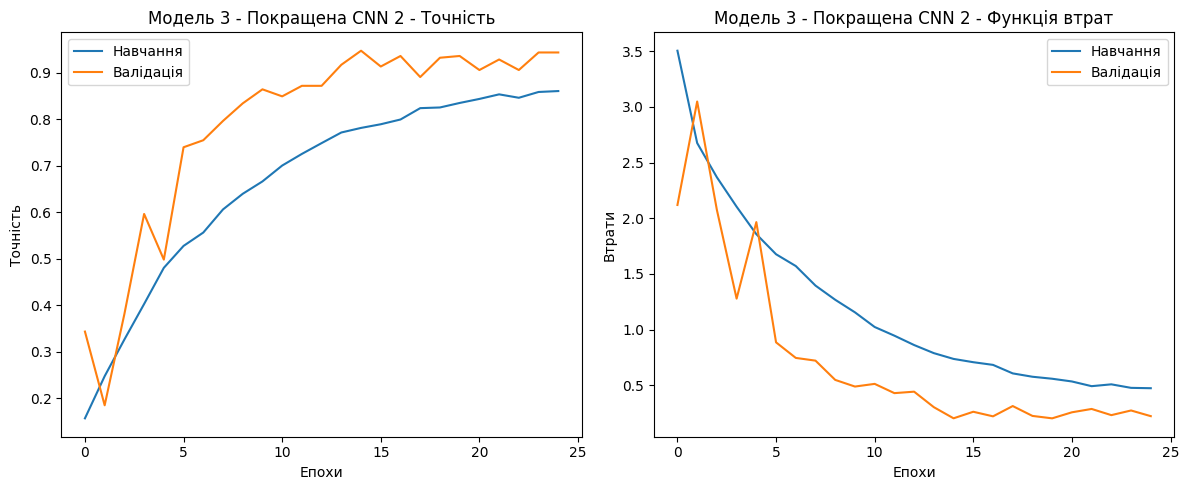

Максимальна точність валідації: 0.9472
Мінімальні втрати валідації: 0.2024


In [ ]:
# Візуалізуємо результати
plot_training_history(history_improved_cnn2, title='Модель 3.1 - Покращена CNN')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599,541 (9.92 MB)

 Trainable params: 341,557 (1.30 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 67s 238ms/step - accuracy: 0.0995 - loss: 3.6997 - val_accuracy: 0.3321 - val_loss: 2.2375
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.2631 - loss: 2.5554 - val_accuracy: 0.3811 - val_loss: 1.9295
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 85s 208ms/step - accuracy: 0.3502 - loss: 2.2060 - val_accuracy: 0.4113 - val_loss: 1.7982
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 77s 188ms/step - accuracy: 0.3983 - loss: 2.0509 - val_accuracy: 0.4792 - val_loss: 1.7246
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 194ms/step - accuracy: 0.4301 - loss: 1.9188 - val_accuracy: 0.4906 - val_loss: 1.6125
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 58s 243ms/step - accuracy: 0.4484 - loss: 1.8241 - val_accuracy: 0.4679 - val_loss: 1.5882
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 55s 229ms/step - accuracy: 0.4744 - loss: 1.7324 - val_accuracy: 0.4906 - val_loss: 1.5822
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 52s 216ms/step - accuracy: 0.4812 - loss: 1

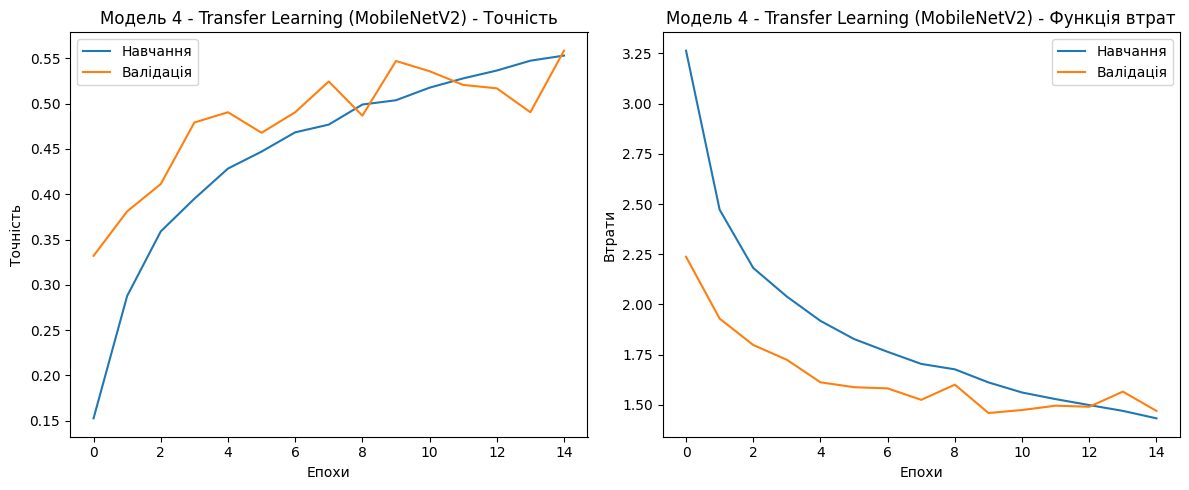

Максимальна точність валідації: 0.5585
Мінімальні втрати валідації: 1.4596


In [ ]:
def build_transfer_learning_model(base_model_name='mobilenetv2', input_shape=(128, 128, 3), num_classes=53, trainable=False):
    with strategy.scope():
        # Вибір базової моделі
        base_model = MobileNetV2(
                weights='imagenet',
                include_top=False,
                input_shape=input_shape
        )
        base_model.trainable = trainable

        # Створення моделі
        inputs = Input(shape=input_shape)
        x = base_model(inputs, training=False)  # training=False для BatchNorm
        x = GlobalAveragePooling2D()(x) # замість Flatten - краще для transfer learning
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Будуємо модель на основі MobileNetV2
tl_model_mobilenet = build_transfer_learning_model(base_model_name='mobilenetv2', trainable=False)
tl_model_mobilenet.summary()

# Навчаємо модель з аугментацією
history_tl_mobilenet = tl_model_mobilenet.fit(
    train_generator_aug, ## (сильна)
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_tl_mobilenet.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = tl_model_mobilenet.evaluate(test_generator)
print(f"Тестова точність MobileNetV2 (заморожена): {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_tl_mobilenet, title='Модель 4 - Transfer Learning (MobileNetV2)')

Знайдено базову модель: mobilenetv2_1.00_128
Заморожено перші 100 шарів базової моделі. Всього шарів: 154


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,599,541 (9.92 MB)

 Trainable params: 2,202,997 (8.40 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 84s 252ms/step - accuracy: 0.1884 - loss: 3.2513 - val_accuracy: 0.2566 - val_loss: 3.0822
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.4971 - loss: 1.7840 - val_accuracy: 0.3170 - val_loss: 2.7926
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.6155 - loss: 1.3823 - val_accuracy: 0.3208 - val_loss: 2.7495
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.6774 - loss: 1.1311 - val_accuracy: 0.1660 - val_loss: 5.8745
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 190ms/step - accuracy: 0.7172 - loss: 1.0322 - val_accuracy: 0.4679 - val_loss: 2.1638
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.7342 - loss: 0.9512 - val_accuracy: 0.4792 - val_loss: 2.4735
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 192ms/step - accuracy: 0.7502 - loss: 0.8937 - val_accuracy: 0.4604 - val_loss: 2.7639
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 188ms/step - accuracy: 0.7715 - loss: 0

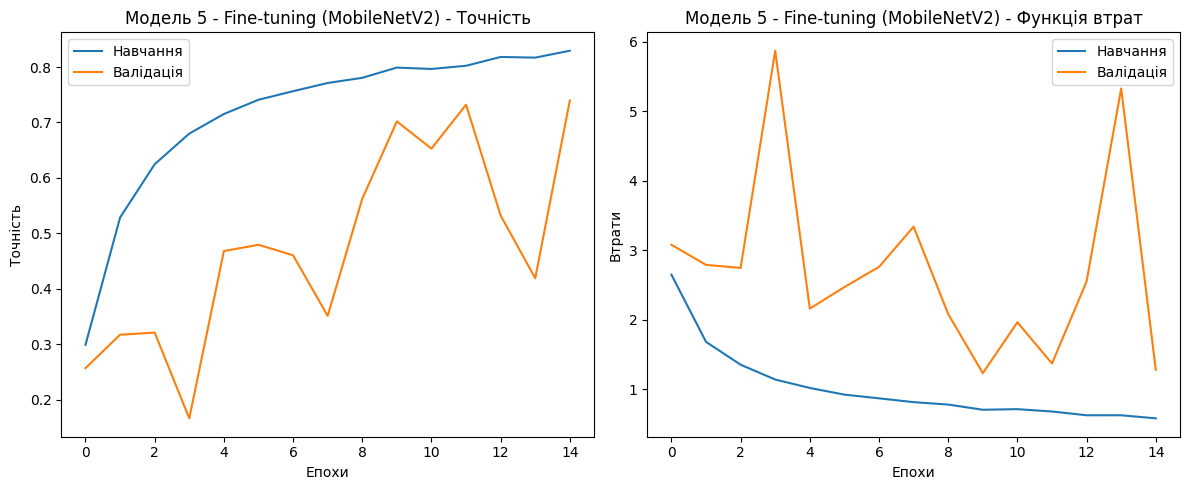

Максимальна точність валідації: 0.7396
Мінімальні втрати валідації: 1.2349


In [ ]:
# Fine-tuning MobileNetV2
# Розморозимо декілька верхніх шарів MobileNetV2 для тонкого налаштування
tl_model_mobilenet_finetune = build_transfer_learning_model(base_model_name='mobilenetv2', trainable=True)

# Знаходимо базову модель в архітектурі
base_model = None
for layer in tl_model_mobilenet_finetune.layers:
    if isinstance(layer, tf.keras.Model):  # Шукаємо вкладену модель (базову модель)
        base_model = layer
        break

# Якщо базову модель знайдено, заморозимо її перші N шарів
if base_model is not None:
    # Заморозимо перші 100 шарів, залишивши верхні шари тренувальними
    for i, layer in enumerate(base_model.layers):
        if i < 100:
            layer.trainable = False
        else:
            layer.trainable = True
    print(f"Заморожено перші 100 шарів базової моделі. Всього шарів: {len(base_model.layers)}")

# Компілюємо модель
tl_model_mobilenet_finetune.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tl_model_mobilenet_finetune.summary()

# Навчаємо модель з тонким налаштуванням
history_tl_mobilenet_finetune = tl_model_mobilenet_finetune.fit(
    train_generator_aug, ## слабка
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_tl_mobilenet_finetune.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = tl_model_mobilenet_finetune.evaluate(test_generator)
print(f"Тестова точність MobileNetV2 (fine-tuning): {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_tl_mobilenet_finetune, title='Модель 5 - Fine-tuning (MobileNetV2)')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 401,845 (1.53 MB)

 Trainable params: 399,925 (1.53 MB)

 Non-trainable params: 1,920 (7.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 70s 245ms/step - accuracy: 0.0609 - loss: 4.0457 - val_accuracy: 0.0566 - val_loss: 5.2151
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 194ms/step - accuracy: 0.1247 - loss: 3.2192 - val_accuracy: 0.0189 - val_loss: 7.3620
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 88s 218ms/step - accuracy: 0.1745 - loss: 2.8266 - val_accuracy: 0.2113 - val_loss: 2.6391
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.2855 - loss: 2.4602 - val_accuracy: 0.1472 - val_loss: 3.0985
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 81s 195ms/step - accuracy: 0.3611 - loss: 2.2093 - val_accuracy: 0.3094 - val_loss: 2.2715
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 190ms/step - accuracy: 0.4185 - loss: 2.0360 - val_accuracy: 0.2264 - val_loss: 2.7649
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 191ms/step - accuracy: 0.4737 - loss: 1.8637 - val_accuracy: 0.2679 - val_loss: 2.6560
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 49s 206ms/step - accuracy: 0.5127 - loss: 1

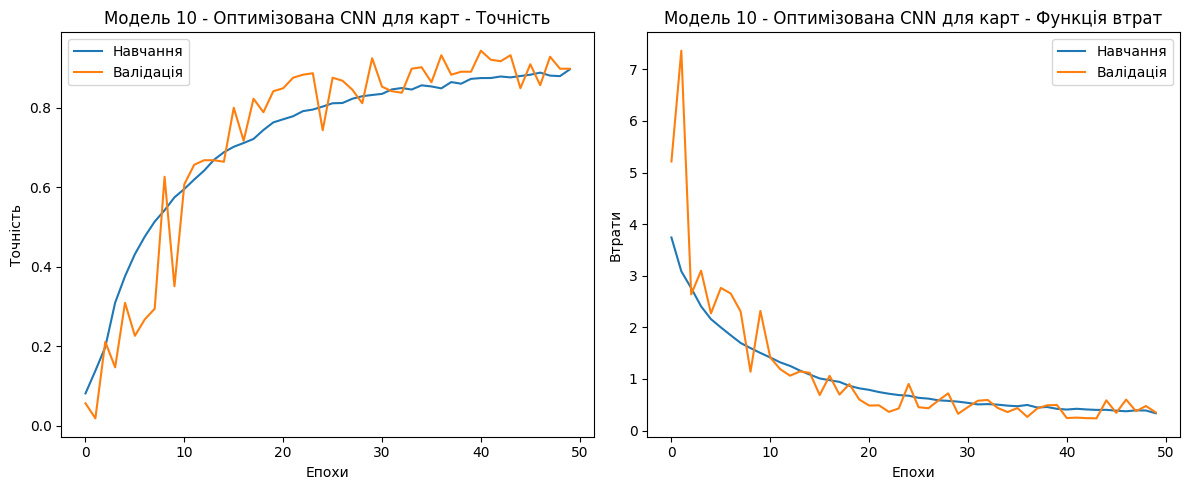

Максимальна точність валідації: 0.9434
Мінімальні втрати валідації: 0.2369


In [ ]:
# Модель 6 - ще одна оптимізована CNN
def build_optimized_cnn(input_shape=(128, 128, 3), num_classes=53):
    with strategy.scope():
        model = Sequential([
            # Змінений вхідний блок для карт
            Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((3, 3), strides=(2, 2), padding='same'),

            # Блок для вивчення дрібних деталей
            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            Conv2D(64, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((2, 2)),

            # Блок для вивчення середніх деталей
            Conv2D(128, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            Conv2D(128, (3, 3), padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((2, 2)),

            # Класифікатор
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'), # Більше шарів
            BatchNormalization(),
            Dropout(0.5),
            Dense(num_classes, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.005),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

# Додаємо необхідний імпорт
from tensorflow.keras.layers import Activation

# Будуємо оптимізовану модель
optimized_cnn = build_optimized_cnn()
optimized_cnn.summary()

# Навчаємо модель з м'якшою аугментацією
history_optimized_cnn = optimized_cnn.fit(
    train_generator_aug,  # слабка аугментація
    validation_data=validation_generator,
    epochs=50, # більше епох
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint('best_optimized_cnn.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = optimized_cnn.evaluate(test_generator)
print(f"Тестова точність оптимізованої CNN для карт: {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_optimized_cnn, title='Модель 10 - Оптимізована CNN для карт')

In [ ]:
def build_transfer_learning_efficientnetb3(input_shape=(128, 128, 3), num_classes=53, trainable=False):
    with strategy.scope():
        # Завантажуємо EfficientNetB3 як базову модель
        base_model = EfficientNetB3(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape
        )

        # Заморозка всіх шарів базової моделі
        base_model.trainable = trainable

        # Створення моделі
        inputs = Input(shape=input_shape)
        x = base_model(inputs, training=False)  # training=False для BatchNorm
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    return model

In [ ]:
# Послаблення аугментації
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    shear_range=2,              # Маленький нахил
    brightness_range=[0.7, 1.1],
    fill_mode='nearest'
)

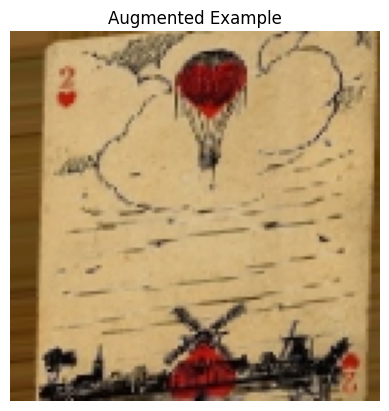

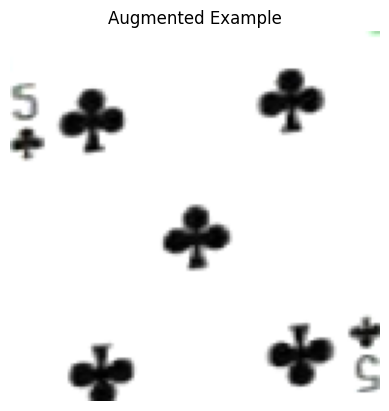

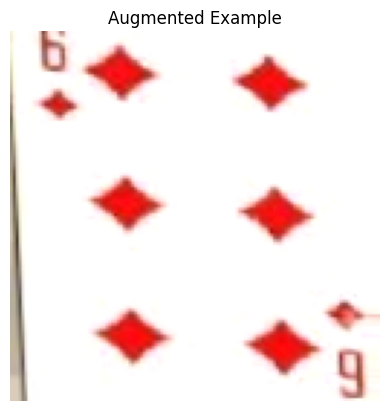

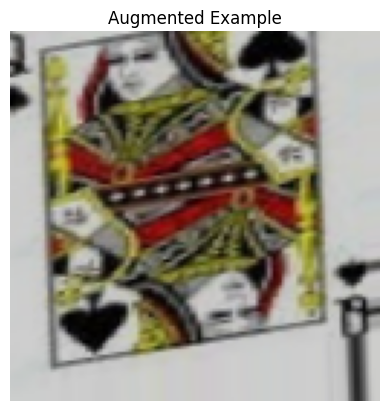

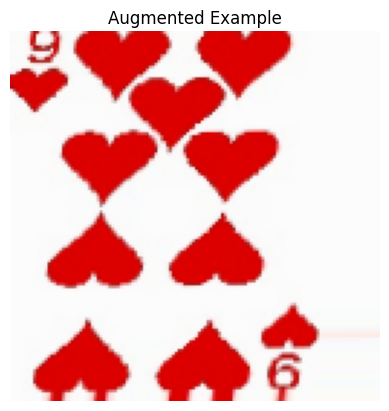

In [ ]:
# Визуализіруємо аугментированні зображення
x_batch, y_batch = next(train_generator_aug)
for i in range(5):
    plt.imshow(x_batch[i])
    plt.title("Augmented Example")
    plt.axis('off')
    plt.show()

Знайдено базову модель: efficientnetb3
Заморожено перші 115 шарів базової моделі EfficientNetB3. Всього шарів: 385


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 4, 4, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 53)             │        27,189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,597,668 (44.24 MB)

 Trainable params: 11,346,767 (43.28 MB)

 Non-trainable params: 250,901 (980.09 KB)

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 197s 447ms/step - accuracy: 0.1587 - loss: 3.3130 - val_accuracy: 0.5698 - val_loss: 1.5027
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 209ms/step - accuracy: 0.4952 - loss: 1.8626 - val_accuracy: 0.6717 - val_loss: 1.1044
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 209ms/step - accuracy: 0.5705 - loss: 1.5853 - val_accuracy: 0.7698 - val_loss: 0.8291
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 55s 232ms/step - accuracy: 0.6394 - loss: 1.3285 - val_accuracy: 0.7736 - val_loss: 0.9181
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 54s 228ms/step - accuracy: 0.6530 - loss: 1.2563 - val_accuracy: 0.8038 - val_loss: 0.6846
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 52s 217ms/step - accuracy: 0.6858 - loss: 1.1332 - val_accuracy: 0.8113 - val_loss: 0.6915
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 57s 239ms/step - accuracy: 0.7077 - loss: 1.0521 - val_accuracy: 0.8377 - val_loss: 0.6160
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 60s 250ms/step - accuracy: 0.7131 - loss:

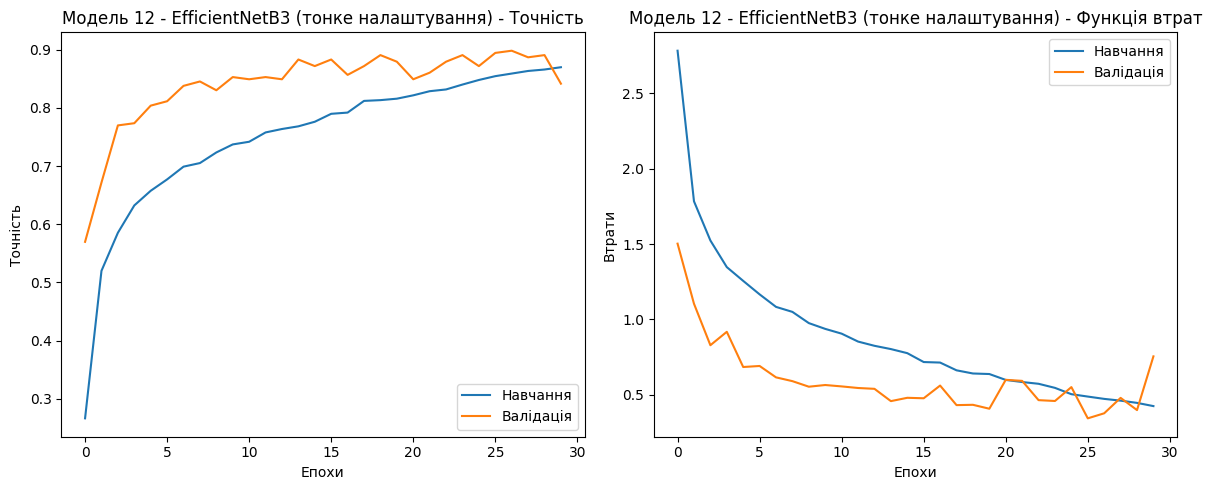

Максимальна точність валідації: 0.8981
Мінімальні втрати валідації: 0.3442


In [ ]:
# Будуємо модель на основі EfficientNetB3 з тонким налаштуванням верхніх шарів
tl_model_efficientnetb3_tuned = build_transfer_learning_efficientnetb3(trainable=True)

# Знаходимо базову модель в архітектурі
base_model = None
for layer in tl_model_efficientnetb3_tuned.layers:
    if isinstance(layer, tf.keras.Model):  # Шукаємо вкладену модель (базову модель)
        base_model = layer
        break

# Якщо базову модель знайдено, заморозимо її перші N шарів
if base_model is not None:
    total_layers = len(base_model.layers)
    freeze_ratio = 0.3  # Заморожуємо 30% шарів
    freeze_layers = int(total_layers * freeze_ratio)

    for i, layer in enumerate(base_model.layers):
        if i < freeze_layers:
            layer.trainable = False
        else:
            layer.trainable = True
    print(f"Заморожено перші {freeze_layers} шарів базової моделі EfficientNetB3. Всього шарів: {total_layers}")

# Компілюємо модель з меншою швидкістю навчання
tl_model_efficientnetb3_tuned.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tl_model_efficientnetb3_tuned.summary()

# Навчаємо модель з тонким налаштуванням
history_tl_efficientnetb3_tuned = tl_model_efficientnetb3_tuned.fit(
    train_generator_aug,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),  # Більше терпіння
        ModelCheckpoint('best_tl_efficientnetb3_tuned.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = tl_model_efficientnetb3_tuned.evaluate(test_generator)
print(f"Тестова точність EfficientNetB3 (тонке налаштування): {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_tl_efficientnetb3_tuned, title='Модель 12 - EfficientNetB3 (тонке налаштування)')

Знайдено базову модель: efficientnetb3
Заморожено перші 308 шарів базової моделі EfficientNetB3. Всього шарів: 385


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 4, 4, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 53)             │        27,189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,597,668 (44.24 MB)

 Trainable params: 7,240,173 (27.62 MB)

 Non-trainable params: 4,357,495 (16.62 MB)

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 134s 350ms/step - accuracy: 0.0394 - loss: 3.9076 - val_accuracy: 0.0566 - val_loss: 3.6370
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.0829 - loss: 3.5749 - val_accuracy: 0.0717 - val_loss: 3.2871
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.1095 - loss: 3.3438 - val_accuracy: 0.1585 - val_loss: 3.5325
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 192ms/step - accuracy: 0.1523 - loss: 3.1406 - val_accuracy: 0.1509 - val_loss: 3.3053
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 211ms/step - accuracy: 0.1759 - loss: 3.0453 - val_accuracy: 0.3170 - val_loss: 2.3682
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 53s 222ms/step - accuracy: 0.1944 - loss: 2.9348 - val_accuracy: 0.2830 - val_loss: 2.2600
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 53s 223ms/step - accuracy: 0.1955 - loss: 2.9156 - val_accuracy: 0.2943 - val_loss: 2.2321
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 212ms/step - accuracy: 0.2244 - loss: 

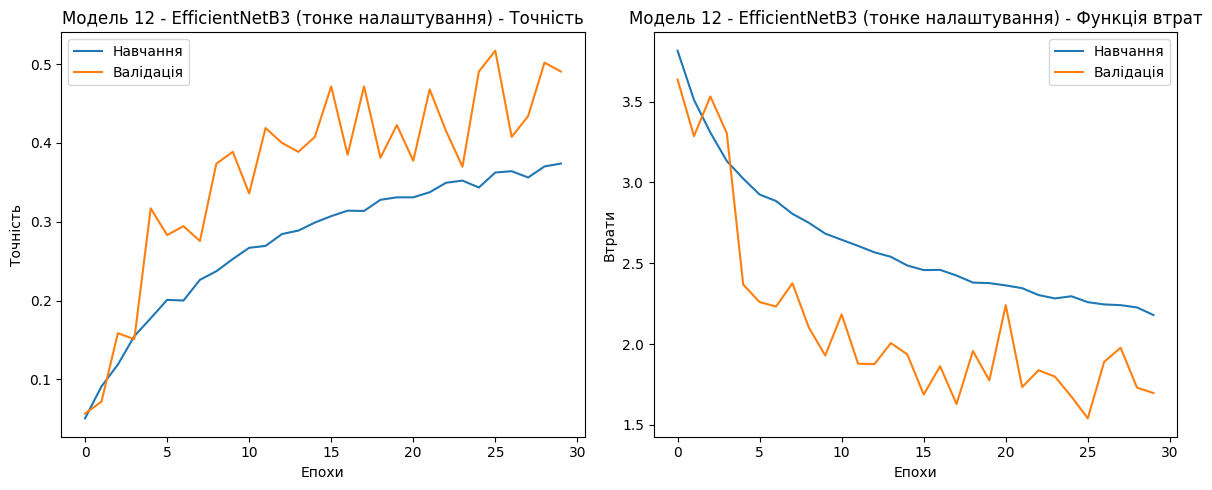

Максимальна точність валідації: 0.5170
Мінімальні втрати валідації: 1.5404


In [ ]:
# Будуємо модель на основі EfficientNetB3 з тонким налаштуванням верхніх шарів
tl_model_efficientnetb3_tuned = build_transfer_learning_efficientnetb3(trainable=True)

# Знаходимо базову модель в архітектурі
base_model = None
for layer in tl_model_efficientnetb3_tuned.layers:
    if isinstance(layer, tf.keras.Model):  # Шукаємо вкладену модель (базову модель)
        base_model = layer
        break

# Перевіряємо, чи знайшли базову модель
if base_model is None:
    print("УВАГА: Не вдалося знайти базову модель EfficientNetB3 як шар")
    # Альтернативний спосіб - отримуємо базову модель за індексом (може відрізнятися)
    try:
        base_model = tl_model_efficientnetb3_tuned.layers[1]  # Зазвичай другий шар - це базова модель
        print(f"Використовуємо шар {base_model.name} як базову модель")
    except:
        print("Помилка при отриманні базової моделі EfficientNetB3. Тонке налаштування неможливе.")
else:
    print(f"Знайдено базову модель: {base_model.name}")

# Якщо базову модель знайдено, заморозимо її перші N шарів
if base_model is not None:
    total_layers = len(base_model.layers)
    freeze_ratio = 0.8  # Заморожуємо 80% шарів
    freeze_layers = int(total_layers * freeze_ratio)

    for i, layer in enumerate(base_model.layers):
        if i < freeze_layers:
            layer.trainable = False
        else:
            layer.trainable = True
    print(f"Заморожено перші {freeze_layers} шарів базової моделі EfficientNetB3. Всього шарів: {total_layers}")

# Компілюємо модель з меншою швидкістю навчання
tl_model_efficientnetb3_tuned.compile(
    optimizer=Adam(learning_rate=0.0005),  # мала швидкість навчання для тонкого налаштування
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tl_model_efficientnetb3_tuned.summary()

# Навчаємо модель з тонким налаштуванням
history_tl_efficientnetb3_tuned = tl_model_efficientnetb3_tuned.fit(
    train_generator_aug,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),  # Більше терпіння
        ModelCheckpoint('best_tl_efficientnetb3_tuned.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = tl_model_efficientnetb3_tuned.evaluate(test_generator)
print(f"Тестова точність EfficientNetB3 (тонке налаштування): {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_tl_efficientnetb3_tuned, title='Модель 12 - EfficientNetB3 (тонке налаштування)')

In [ ]:
# Будуємо модель на основі EfficientNetB3 з повною заморозкою
tl_model_efficientnetb3_frozen = build_transfer_learning_efficientnetb3(trainable=False)
tl_model_efficientnetb3_frozen.summary()

# Навчаємо модель з аугментацією
history_tl_efficientnetb3_frozen = tl_model_efficientnetb3_frozen.fit(
    train_generator_aug,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_tl_efficientnetb3_frozen.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
    ],
    verbose=1
)

# Оцінюємо на тестовому наборі
test_loss, test_accuracy = tl_model_efficientnetb3_frozen.evaluate(test_generator)
print(f"Тестова точність EfficientNetB3 (повна заморозка): {test_accuracy:.4f}")

# Візуалізуємо результати
plot_training_history(history_tl_efficientnetb3_frozen, title='Модель 11 - EfficientNetB3 (повна заморозка)')

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 4, 4, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 53)             │        27,189 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,597,668 (44.24 MB)

 Trainable params: 814,133 (3.11 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 112s 328ms/step - accuracy: 0.0235 - loss: 4.0195 - val_accuracy: 0.0491 - val_loss: 3.8644
Epoch 2/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.0419 - loss: 3.8692 - val_accuracy: 0.0340 - val_loss: 3.7937
Epoch 3/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 47s 195ms/step - accuracy: 0.0372 - loss: 3.8132 - val_accuracy: 0.0491 - val_loss: 3.7102
Epoch 4/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 185ms/step - accuracy: 0.0462 - loss: 3.7666 - val_accuracy: 0.0453 - val_loss: 3.6487
Epoch 5/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.0506 - loss: 3.7534 - val_accuracy: 0.0453 - val_loss: 3.6353
Epoch 6/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 46s 194ms/step - accuracy: 0.0464 - loss: 3.7337 - val_accuracy: 0.0679 - val_loss: 3.5599
Epoch 7/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 187ms/step - accuracy: 0.0487 - loss: 3.7076 - val_accuracy: 0.0377 - val_loss: 3.5723
Epoch 8/30
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 186ms/step - accuracy: 0.0549 - loss: 

KeyboardInterrupt: 